`--- Day 7: The Sum of Its Parts ---`

In [1]:
import networkx as nx
import re
from collections import deque

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
instructions = open('input.txt').read().splitlines()

In [3]:
test_instructions = '''Step C must be finished before step A can begin.
Step C must be finished before step F can begin.
Step A must be finished before step B can begin.
Step A must be finished before step D can begin.
Step B must be finished before step E can begin.
Step D must be finished before step E can begin.
Step F must be finished before step E can begin.
'''.splitlines()

test_order = 'CABDFE'

In [4]:
def mkGraph(instr):
    g = nx.DiGraph()
    for i in instr:
        pre, post = re.search(r'Step ([A-Z]) must be finished before step ([A-Z]) can begin.', i).groups()
        g.add_edge(pre, post)
    return g

def findStart(g):
    startnodes = [node for node in g if g.in_degree[node] == 0]
    return startnodes

def findEnd(g):
    endnodes = [node for node in g if g.out_degree[node] == 0]
    return endnodes

def drawGraph(g, layout=nx.spring_layout):
    start = findStart(g)
    end = findEnd(g)
    pos = layout(g)
    #pos = nx.spectral_layout(test)
    fig, ax = plt.subplots(figsize=(12, 12))
    nx.draw_networkx_nodes(g, pos, nodelist=start, node_color='green', node_size=900, alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(g, pos, nodelist=end, node_color='red', node_size=900, alpha=0.5, ax=ax)

    nx.draw_networkx(g, pos=pos, node_color='gray', node_size=400, arrowsize=15,font_color='white', font_weight='bold', ax=ax)
    #nx.draw_networkx_labels(g, pos=pos, font_color='white', font_weight='bold', ax=ax)
    return fig, ax

def walkGraph(g):
    start = findStart(g)
    visited = set()
    result = []
    queue = deque(start)
    while queue:
        #queue = sorted(queue)
        # pick first item in queue that has all of its predecessors in [visited]
        here = None
        for i in sorted(queue):
            predecessors = set(g.predecessors(i))
            if predecessors.issubset(visited):
                queue.remove(i)
                here = i
                break
        if here is None:
            return f'Failed to find valid node in {queue}, path is {result}'
        # record the node
        visited.add(here)
        result.append(here)
        # add successors to queue
        for i in g.successors(here):
            if i not in queue:
                queue.append(i)  
    return ''.join(result)

def taskLength(t, base=60):
    return ord(t) - ord('A') + 1 + base

def testTaskLength(t):
    return taskLength(t, base=0)

def parallelWalkGraph(g, nworkers=1, taskLength=taskLength):
    start = findStart(g)
    visited = set()
    result = []
    queue = deque(start)
    time = 0
    inprogress = [] # [('A', 777), ...] node, finishtime
    while queue:
        #queue = sorted(queue)
        # pick items in queue that have all of its predecessors in [visited], until all workers are busy
        for i in sorted(queue):
            predecessors = set(g.predecessors(i))
            if predecessors.issubset(visited) and len(inprogress) < nworkers:
                queue.remove(i)
                inprogress.append((i, time + taskLength(i)))
        #print('in progress =', inprogress)
        if len(inprogress) == 0:
            return f'Failed to find valid node in {queue}, path is {result}'
        # find the next finishing task(s)
        time = min(t[1] for t in inprogress)
        for t in [s for s in inprogress if s[1] == time]:
            here = t[0]
            visited.add(here)
            result.append(here)
            # add successors to queue
            for i in g.successors(here):
                if i not in queue:
                    queue.append(i)  
        inprogress = [t for t in inprogress if t[1] != time]
        #print(result, inprogress, queue, time) 
    return ''.join(result), time

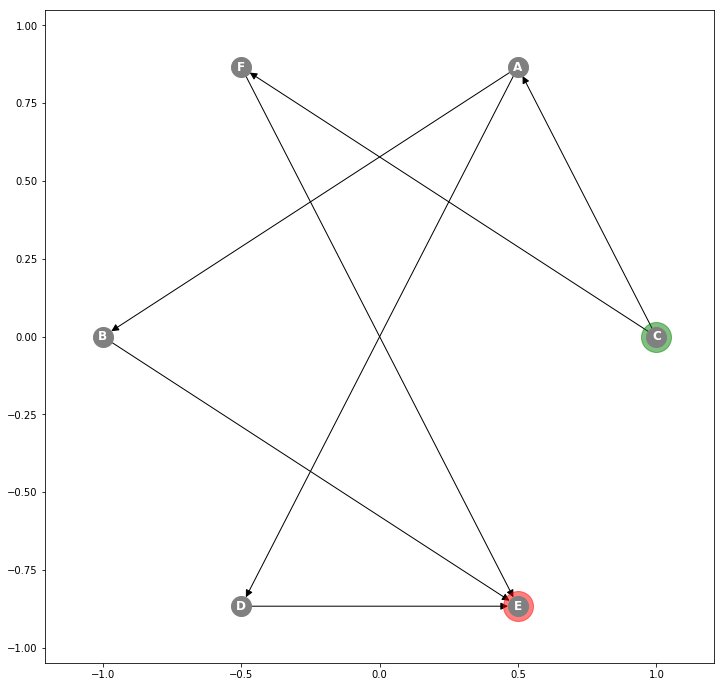

In [5]:
test = mkGraph(test_instructions)
fig, ax = drawGraph(test, layout=nx.circular_layout)

In [6]:
assert(walkGraph(test) == test_order)

# Part 1

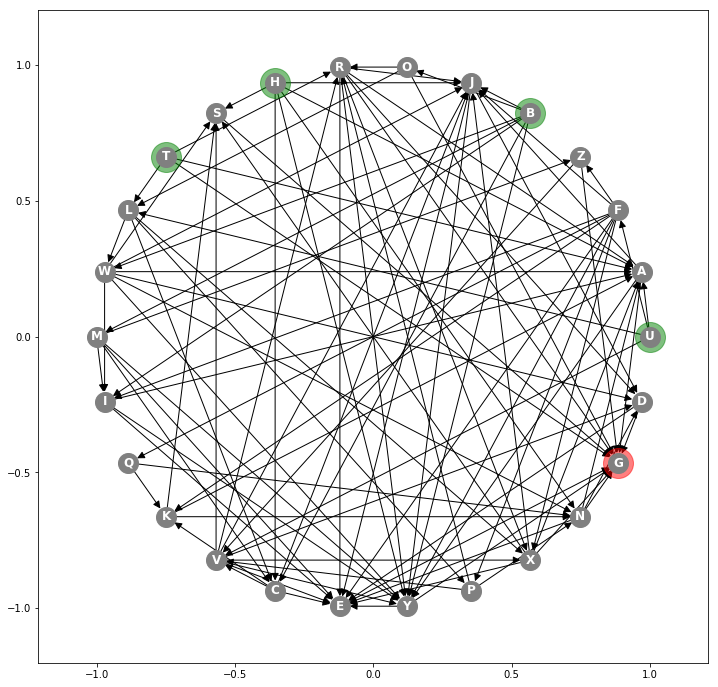

In [7]:
part1g = mkGraph(instructions)
fig, ax = drawGraph(part1g, layout=nx.circular_layout)

In [8]:
walkGraph(part1g)

'BHMOTUFLCPQKWINZVRXAJDSYEG'

# Part 2

To simplify things for the example, however, suppose you only have help from one Elf (a total of two workers) and that each step takes 60 fewer seconds (so that step A takes 1 second and step Z takes 26 seconds). Then, using the same instructions as above, this is how each second would be spent:
```
Second   Worker 1   Worker 2   Done
   0        C          .        
   1        C          .        
   2        C          .        
   3        A          F       C
   4        B          F       CA
   5        B          F       CA
   6        D          F       CAB
   7        D          F       CAB
   8        D          F       CAB
   9        D          .       CABF
  10        E          .       CABFD
  11        E          .       CABFD
  12        E          .       CABFD
  13        E          .       CABFD
  14        E          .       CABFD
  15        .          .       CABFDE
```
Each row represents one second of time. The Second column identifies how many seconds have passed as of the beginning of that second. Each worker column shows the step that worker is currently doing (or . if they are idle). The Done column shows completed steps.

Note that the order of the steps has changed; this is because steps now take time to finish and multiple workers can begin multiple steps simultaneously.

In this example, it would take 15 seconds for two workers to complete these steps.

In [9]:
assert(parallelWalkGraph(test, nworkers=2, taskLength=testTaskLength) == ('CABFDE', 15))

In [10]:
parallelWalkGraph(part1g, nworkers=5)

('BHTUMOFLQZCPWKIVNRXASJDYEG', 877)

# Relationship between time taken and the number of workers

In [11]:
time = []
workers = list(range(1, 7))
for i in workers:
    time.append(parallelWalkGraph(part1g, nworkers=i)[1])

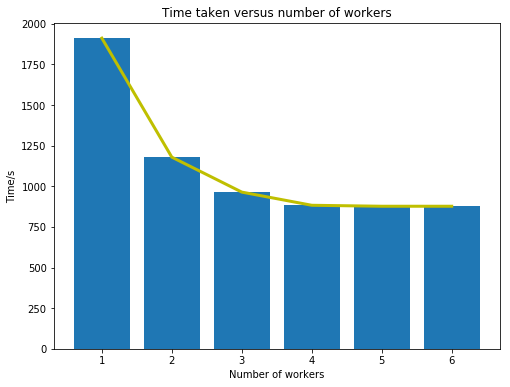

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(workers, time)
ax.plot(workers, time, 'y', linewidth=3)
ax.set_title('Time taken versus number of workers')
ax.set_xlabel('Number of workers')
ax.set_ylabel('Time/s')
plt.show()